In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import lal
import copy
import pickle
import copy
import pandas as pd
import corner
import torch

In [11]:
from pyRing.waveform import KerrBH
from pycbc.detector import Detector
from pyRing.likelihood import project
from tqdm import tqdm
from pyRing.noise import bandpass_data
from pyRing.utils import whiten_TD

In [12]:
from scipy.linalg import toeplitz
from scipy.stats       import multivariate_normal
from scipy.interpolate import interp1d
from scipy.signal      import butter, filtfilt

In [4]:
load_priors = True
load_strain =  False
prior_path = '/Users/rcotesta/Projects/neural_ringdowns/simulation_based_inference_ringdown/data/priors/'
strain_path = '/Users/rcotesta/Projects/neural_ringdowns/simulation_based_inference_ringdown/data/h/'
noise_path = '/Users/rcotesta/Projects/neural_ringdowns/simulation_based_inference_ringdown/data/noise/'
whitened_signal_path = '/Users/rcotesta/Projects/neural_ringdowns/simulation_based_inference_ringdown/data/whitened_signal/'
bandpassed_signal_path = '/Users/rcotesta/Projects/neural_ringdowns/simulation_based_inference_ringdown/data/bandpassed_signals/'
prior_file = 'prior_Mf_20_150_af_0.00_0.99_A0_1e-21_5e-20_phi_0.00_6.28.npy'
strain_filename = 'strain_Mf_20_150_af_0.00_0.99_A0_1e-21_5e-20_phi_0.00_6.28_srate_2048Hz_duration_0.024s.npy'

# Definition global settings signal and parameter space

In [5]:
# Set the interferometer
ifo = 'H1'

# Setting sky position, arrival time and inclination
ra, dec, psi = 1.95, -1.27, 0.82
tGPS = 1126259462.4083046
inclination = np.pi

# Setting sampling rate and duration
sr = 2048
dt = 1/sr
tmax = 50./sr
fmax = 1022.
fmin = 20.
times = np.arange(0,tmax,dt)

# Set the prior bounds on final mass, spins, amplitudes and phases
prior_bounds = {}
prior_bounds['Mf'] = [20,150] 
prior_bounds['af'] = [0,0.99]
prior_bounds['A0'] = [1e-21,5e-20]
prior_bounds['phi'] = [0,2*np.pi]


priors = {}
# number of points in the prior
Nprior = int(1e6)
# option to load the prior from outside or to generate it
if load_priors == True:
    prior_loaded = np.load(prior_path+prior_file)
    priors['Mf'] = prior_loaded[:,0]
    priors['af'] = prior_loaded[:,1]
    priors['A0'] = prior_loaded[:,2]
    priors['phi'] = prior_loaded[:,3]
else:
    # generate the prior
    priors = {key:np.random.uniform(*prior_bounds[key],size=Nprior) for key in prior_bounds.keys()}
    prior_file = 'prior_Mf_{:.0f}_{:.0f}_af_{:.2f}_{:.2f}_A0_{}_{}_phi_{:.2f}_{:.2f}.npy'.format(*np.array(list(prior_bounds.values()),dtype=float).reshape(8,))
    np.save(prior_path+prior_file,np.column_stack(list(priors.values())))

# Generate signals

In [19]:
# Option to generate the signals or to load them from outside
if load_strain == True:
    strains = np.load(strain_path+strain_filename)
else:
    amps = {}
    labels = np.load(prior_path+prior_file)
    nsamples, nparams = labels.shape
    strains = np.zeros((nsamples,len(times)))
    for i in tqdm(range(nsamples)):
        Mf, af, amps[2,2,2,0], phi = labels[i]
        # Generate signals using pyRing
        Kerr = KerrBH(0., Mf, af,amps,1.,inclination,phi,None,amp_non_prec_sym = 1,reference_amplitude = 1)
        # Projection of the signals in the polarization basis
        hs, hvx, hvy, hp, hc = Kerr.waveform(times)
        # Projection of the signals in the detectors
        h = project(hs, hvx, hvy, hp, hc, lal.cached_detector_by_prefix[ifo], ra, dec, psi, tGPS)
        strains[i] = h 
    # save signals    
    strain_filename = 'strain_Mf_{:.0f}_{:.0f}_af_{:.2f}_{:.2f}_A0_{}_{}_phi_{:.2f}_{:.2f}_srate_{}Hz_duration_{:.3f}s.npy'.format(*np.array(list(prior_bounds.values()),dtype=float).reshape(8,),sr,tmax)
    np.save(strain_path+strain_filename,strains)    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [05:05<00:00, 3273.00it/s]


# Generate noise

In [20]:
# load PSD
freqs, H1_PSD, L1_PSD = np.loadtxt('./GWTC1_GW150914_PSDs.dat',delimiter='\t',unpack=True,skiprows=1,dtype=np.float64)

In [21]:
# generate noise and add it to the signal
noises = np.zeros(strains.shape)
for i in tqdm(range(strains.shape[0])):
    # Since I will whiten the signal, I am already generating white noise
    noises[i] = np.random.normal(size=len(times))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:01<00:00, 596427.72it/s]


In [25]:
#save noise
noise_filename = 'white_noise_T_segment_{:.2f}s_srate_{}Hz.npy'.format(tmax,sr)
np.save(noise_path+noise_filename,noises)

## Whiten strain

In [26]:
# load PSD
freqs, H1_PSD, L1_PSD = np.loadtxt('./GWTC1_GW150914_PSDs.dat',delimiter='\t',unpack=True,skiprows=1,dtype=np.float64)

In [27]:
# compute noise properties
multiple_tmax = 1
tmax_noise = multiple_tmax*tmax
N_points  = int(tmax_noise*sr)
psd_cgn   = interp1d(freqs, H1_PSD, fill_value='extrapolate', bounds_error=False)
freqs_cgn = np.fft.rfftfreq(N_points, d = dt)
df_cgn    = np.diff(freqs_cgn)[0]

# computing autocorrelation matrix from PSD
ACF_cgn            = 0.5*np.real(np.fft.irfft(psd_cgn(freqs_cgn)*df_cgn))*N_points
# toeplitz decomposition of autocorrelation function
C_cgn              = toeplitz(ACF_cgn)
cgn                = multivariate_normal(mean = np.zeros(C_cgn.shape[0]), cov = C_cgn)
# cholesky decomposition of autocorrelation matrix
cholesky_matrix = np.linalg.cholesky(C_cgn)

In [33]:
whiten_strains = np.zeros((nsamples,len(times)))
# compute whiten signals
whiten_strains = np.array([whiten_TD(strains[i],cholesky_matrix) for i in range(nsamples)])

In [44]:
# add whiten signals to noise
signals = whiten_strains + noises

In [46]:
#save signals
whitened_signal_file = 'signal_withened_Mf_{:.0f}_{:.0f}_af_{:.2f}_{:.2f}_A0_{}_{}_phi_{:.2f}_{:.2f}_T_segment_{:.2f}s_srate_{}Hz.npy'.format(*np.array(list(prior_bounds.values()),dtype=float).reshape(8,),tmax,sr)
np.save(whitened_signal_path+whitened_signal_file,signals)

## Compute SNR

In [8]:
from pyRing.utils import compute_SNR_TD

In [48]:
SNRs = np.array([compute_SNR_TD(strains[i], strains[i], cholesky_matrix, method='cholesky-solve-triangular') for i in range(len(strains))])

## Bandpass signal

In [18]:
# bandbass signals
signals_bandpassed = np.zeros(strains.shape)
for i in tqdm(range(signals.shape[0])):
    bb, ab = butter(4, [fmin/(0.5*sr), fmax/(0.5*sr)], btype='band')
    signals_bandpassed[i] = filtfilt(bb, ab, signals[i])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [02:08<00:00, 7800.34it/s]


In [24]:
#save bandpassed signal
signal_bandpassed_file = 'signal_bandpassed_Mf_{:.0f}_{:.0f}_af_{:.2f}_{:.2f}_A0_{}_{}_phi_{:.2f}_{:.2f}_T_segment_{:.2f}s_T_noise_{:.3f}s_srate_{}Hz.npy'.format(*np.array(list(prior_bounds.values()),dtype=float).reshape(8,),tmax_noise,tmax,sr)
np.save(bandpassed_signal_path+signal_bandpassed_file,signals_bandpassed)

In [41]:
np.save('/Users/rcotesta/Projects/neural_ringdowns/simulation_based_inference_ringdown/data/train_samples_signals_bandpassed_def_2048.npy',signals_bandpassed)

# Test model

In [6]:
## load model
with open('/Users/rcotesta/Projects/neural_ringdowns/simulation_based_inference_ringdown/data/model_data/maf_whitened_Kerr220_def_2048_1E+05_hidden_features_50_num_trasforms_10_norm.pkl', "rb") as handle:
    posterior_generator = pickle.load(handle)

In [7]:
# Import upper values prior for normalization
norms = np.array([prior_bounds['Mf'][1],prior_bounds['af'][1],prior_bounds['A0'][1],prior_bounds['phi'][1]]).reshape(-1,1)

In [8]:
# Import signals for the test
signals_whiten = torch.from_numpy(np.load(whitened_signal_path+whitened_signal_file)).to(torch.float32)
labels = np.load(prior_path+prior_file)

NameError: name 'whitened_signal_file' is not defined

In [9]:
# Standardize data as in training set 
# standardize
signals_whiten_normalized = (signals_whiten-signals_whiten.mean(dim=1).reshape(-1,1))/signals_whiten.std(dim=1).reshape(-1,1)
ntrain = int(1e5)
signals_whiten_normalized = (signals_whiten_normalized-signals_whiten_normalized[:ntrain].mean(dim=0))/signals_whiten_normalized[:ntrain].std(dim=0)

NameError: name 'signals_whiten' is not defined

In [152]:
# Generate samples on test set


## Numer of examples in test set
N_test_set = 100

# test_set = signals_whiten_normalized[-N_test_set:]
# test_labels = labels[-N_test_set:]

test_set = signals_whiten_normalized[:N_test_set]
test_labels = labels[:N_test_set]

## Single case

In [176]:
# Select event in the test set for computing the posterior distribution
i = 30
samples = posterior_generator.sample((int(1e4),),x=test_set[i])
# Undo normalization of the parameters
samples = np.array(samples)*norms.T

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

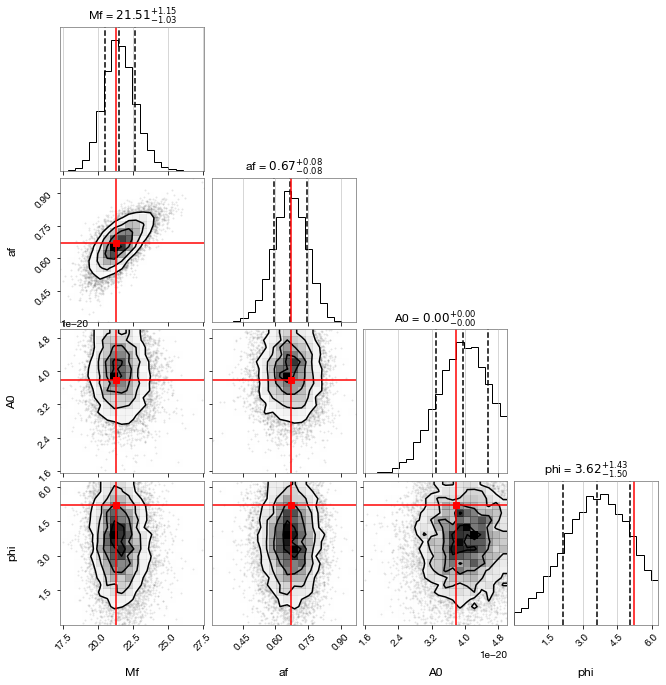

In [177]:
fig = corner.corner(
    samples,
    labels=['Mf','af','A0','phi'],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    truths=test_labels[i],
    truth_color='red'
)

## p-p plot

In [47]:
import bilby

In [143]:
test_samples = []
for i in test_set:
    y = posterior_generator.sample((int(1e3),),x=i)
    y = np.array(y).T
    y = y*norms
    test_samples.append(y)

test_samples = np.array(test_samples)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [146]:
# Generate a prior dict to use Bilby, the range is not important, as it's not used by Bilby
keys_posterior = ["Mf","af",'A0']
priors_Bilby = [bilby.core.prior.analytical.Uniform(*prior_bounds[key], name=key) for key in prior_bounds.keys()]
priors_Bilby = bilby.core.prior.dict.PriorDict(dictionary=dict(zip(keys_posterior,priors_Bilby)))

100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3428.20it/s]
19:49 bilby INFO    : Key: KS-test p-value
19:49 bilby INFO    : Mf: 0.4712020446047783
19:49 bilby INFO    : af: 0.02379018116498932
19:49 bilby INFO    : A0: 0.9063568398670334
19:49 bilby INFO    : Combined p-value: 0.16378298288129653


(<Figure size 432x288 with 1 Axes>,
 pvals(combined_pvalue=0.16378298288129653, pvalues=[0.4712020446047783, 0.02379018116498932, 0.9063568398670334], names=['Mf', 'af', 'A0']))

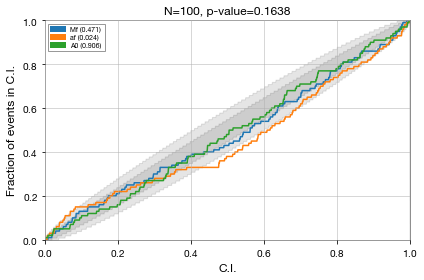

In [148]:
# Convert the posteriors in Bilby format and generate p-p plot using Bilby
results = []
for ii in tqdm(range(N_test_set)):
    posterior = dict()
    injections = dict()
    
    for i_key, key_posterior in enumerate(keys_posterior):
        posterior[key_posterior] = test_samples[ii][i_key]
        injections[key_posterior] = test_labels[ii][i_key]

    posterior = pd.DataFrame(dict(posterior))
    result = bilby.result.Result(
        label="test",
        injection_parameters=injections,
        posterior=posterior,
        search_parameter_keys=injections.keys(),
        priors=priors_Bilby)
    results.append(result)

bilby.result.make_pp_plot(results,confidence_interval=[0.68,0.95,99.7])